In [1]:
import os
from  scipy.optimize import curve_fit
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime

Data transcribed from text statements published here: https://www.essen.de/gesundheit/coronavirus_aktuell.de.html

In [2]:
path = os.path.normpath(r"CoronaCases.csv")
df = pd.read_csv(path,index_col='Day',parse_dates=True,infer_datetime_format=True)
df.head()

,Cases,Active,Tests,Deaths,recovered
Day,,,,,
2020-03-02 19:15:00,1,1,50.0,0,0
2020-03-03 20:00:00,2,2,100.0,0,0
2020-03-04 17:30:00,3,3,250.0,0,0
2020-03-06 17:50:00,4,4,300.0,0,0
2020-03-07 16:30:00,6,6,331.0,0,0


In [3]:
base = datetime.datetime(year=2020,month=3,day=1)
numdays = 56
datelist = [base + datetime.timedelta(days=x) for x in range(0,numdays,7)]

In [4]:
def lin_growth(t,m,b):
    t0 = t[0]
    days = [datetime.timedelta.total_seconds(Ti-t0)/(24*3600) for Ti in t]
    days = np.array(days)
    return (m*(days)+b)

In [5]:
popt,err = curve_fit(lin_growth,df['2020-03-13 00:00':].index,df['2020-03-13 00:00':].Cases)
popt

array([ 12.39676076, 148.44955645])

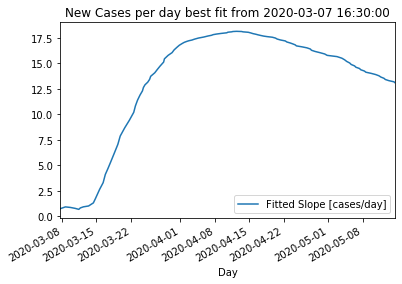

In [6]:
k = []
pd.plotting.register_matplotlib_converters()
start = 4
for i in range(start,len(df.index)):
    a,err = curve_fit(lin_growth,df.index[0:i],df.Cases[0:i])
    df.loc[df.index[i],'Fit'] = a[0]
    df.loc[df.index[i],'error'] = err[0][0]**.5
    

df[start:].plot(y='Fit',use_index=True,label='Fitted Slope [cases/day]')
plt.gca().set_title(f'New Cases per day best fit from {df.index[start]}')
plt.gcf().autofmt_xdate()

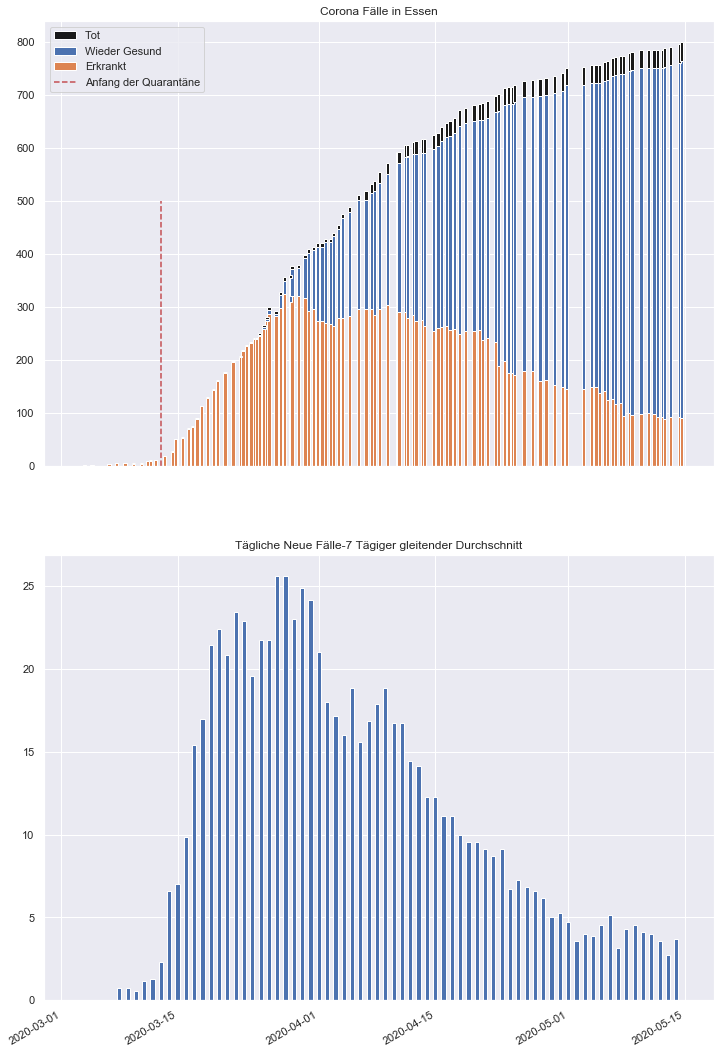

In [7]:
sns.set()
f,axes = plt.subplots(2,1,figsize=(12,20),sharex=True)
ax1 = axes[0]
ax2 = axes[1]
def get_region_line(start,end):
    fit,err = curve_fit(lin_growth,df[start:end].index,df[start:end].Cases)
    return lin_growth(df[start:end].index,fit[0],fit[1])

r1_start = '2020-03-17 21:45:00'
r1_end = '2020-04-23 7:40'

r1_line = get_region_line(r1_start,r1_end)

#p6 = ax1.plot(df[r1_start:r1_end].index,r1_line,c='.3',linestyle='--')


p2 = ax1.bar(x=df.index,height=df['Active'],width=.4,color='C1')
p3 = ax1.bar(x=df.index,height=df['recovered'],bottom=df['Active'],width=.4,color='C0')
p1 = ax1.bar(x=df.index,height=df['Deaths'],bottom=(df['recovered']+df['Active']),width=.4,color='k')
p4 = ax1.vlines(x='2020-03-13 00:00',ymin=0,ymax=500,linestyle='--',color='r')


pd.plotting.register_matplotlib_converters()

ax1.legend((p1[0], p3[0], p2[0],p4,), ('Tot', 'Wieder Gesund','Erkrankt','Anfang der Quarantäne'))

#ax1.set_yscale('log',basey=2)
ax1.set_xticks(datelist)

f.autofmt_xdate()
_ = ax1.set_title('Corona Fälle in Essen')

df['NewCases'] = df['Cases'].diff()
df['NewRecoveries'] = df['recovered'].diff()
daily = df[['NewCases','NewRecoveries']].resample('D').sum()
ax2.bar(x=daily.index,height=daily.NewCases.rolling(window=7).mean(),width=.5)
ax1.vlines
f.autofmt_xdate()
_ = ax2.set_title('Tägliche Neue Fälle-7 Tägiger gleitender Durchschnitt')

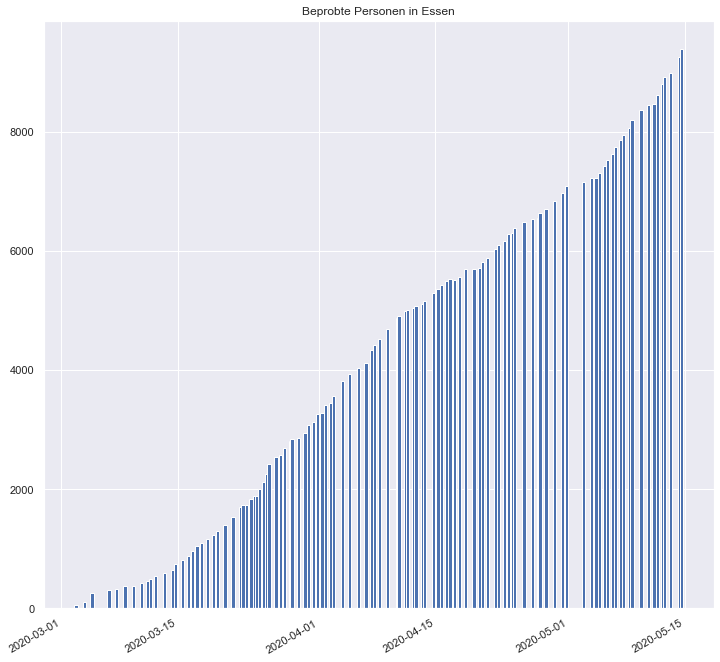

In [8]:
f,ax1 = plt.subplots(figsize=(12,12))
plt.bar(x=df.index,height=df.Tests,width=.4)
f.autofmt_xdate()
_ = ax1.set_title('Beprobte Personen in Essen')
plt.savefig("C:/Users/J33290/Desktop/proben.png",dpi=300,bbox='tight')

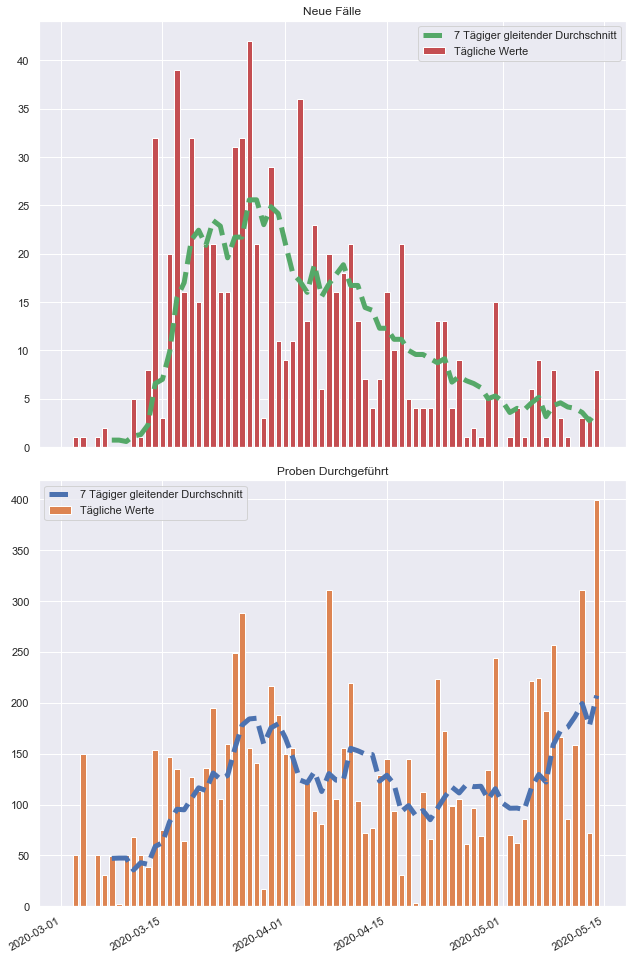

In [13]:
avg_period = 7

df['NewCases'] = df['Cases'].diff()
df['NewRecoveries'] = df['recovered'].diff()
df['NewTests'] = df['Tests'].diff()
daily = df[['NewCases','NewRecoveries','NewTests']].resample('D').sum()

fig,ax = plt.subplots(2,1,figsize=(9,13.5),sharex=True)
ax[1].set_title('Proben Durchgeführt')
ax[1].plot(daily.index,daily.NewTests.rolling(window=avg_period).mean(),label='7 Tägiger gleitender Durchschnitt',color='C0',linestyle='--',linewidth=5)
ax[1].bar(x=daily.index,height=daily.NewTests,width=.75,label='Tägliche Werte',color='C1')
ax[1].legend()

ax[0].set_title('Neue Fälle')
ax[0].plot(daily.index,daily.NewCases.rolling(window=avg_period).mean(),color='C2',label='7 Tägiger gleitender Durchschnitt',linestyle='--',linewidth=5)
ax[0].bar(x=daily.index,height=daily.NewCases,width=.75,color='C3',label='Tägliche Werte')
ax[0].legend()

fig.autofmt_xdate()
fig.tight_layout()
plt.savefig("C:/Users/J33290/Desktop/proben.png",dpi=300,bbox='tight')

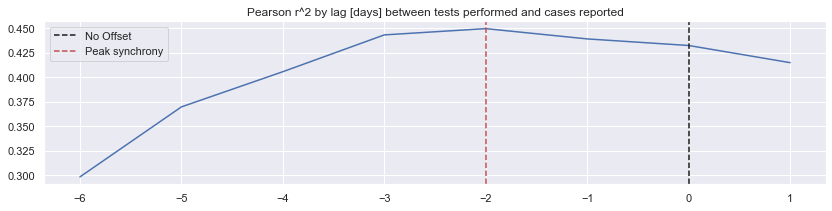

In [10]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))
    
d1 = daily.NewCases.rolling(window=avg_period).mean()
d2 = daily.NewTests.rolling(window=avg_period).mean()
offsets = [x for x in range(-6,2)]
win = 8

rs = [crosscorr(d1,d2, lag) for lag in offsets]
offset = np.ceil(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(range(-int(3*win/4),int(win/4)),rs)
ax.axvline(0,color='k',linestyle='--',label='No Offset')
ax.axvline(offsets[np.argmax(rs)],color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Pearson r^2 by lag [days] between tests performed and cases reported')

plt.legend()
plt.savefig("C:/Users/J33290/Desktop/Synchrony.png",dpi=300,bbox='tight')

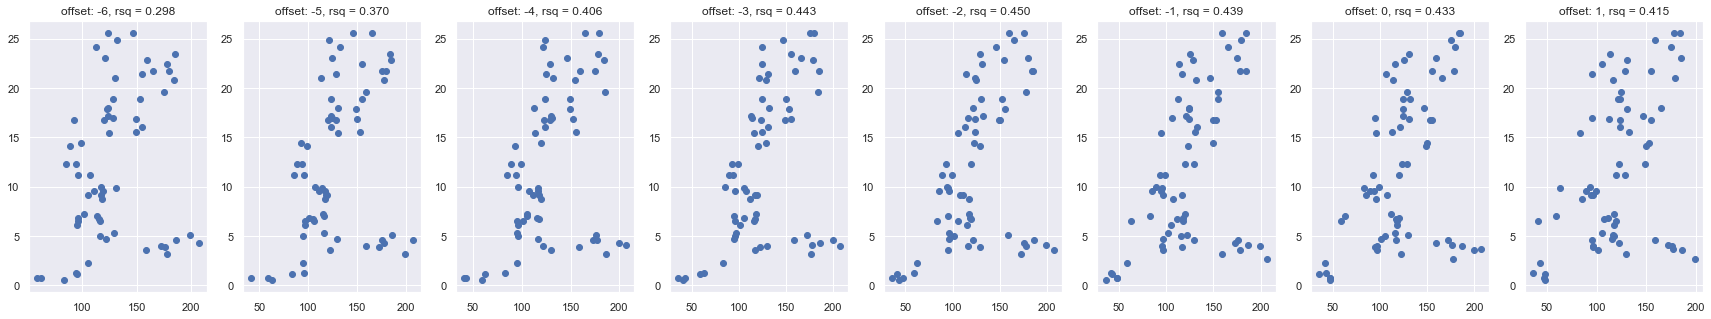

In [11]:
f,ax= plt.subplots(1,len(offsets),figsize=(30,5))
for i in range(len(offsets)):
    ax[i].scatter(daily.NewTests.shift(offsets[i]).rolling(window=avg_period).mean(),daily.NewCases.rolling(window=avg_period).mean())
    ax[i].set_title(f'offset: {offsets[i]}, rsq = {rs[i]:.3f}')


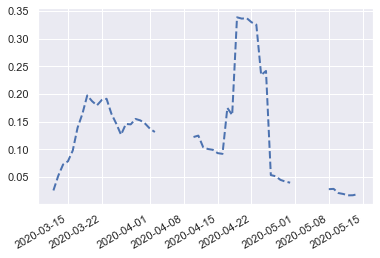

In [12]:
daily['pct']=daily.NewCases/daily.NewTests
plt.plot(daily.index,daily.pct.rolling(window=avg_period).mean(),color='C0',linestyle='--',linewidth=2)
plt.gcf().autofmt_xdate()